# Modelado Causal para la Sostenibilidad de las Pesquerías Marinas mediante Redes Bayesianas

## Contexto:
La sostenibilidad de las pesquerías marinas depende de múltiples factores:

- Ambientales: Temperatura del agua, salinidad, pH, niveles de nutrientes y contaminantes.
- Operativos: Tamaño y edad de la flota, consumo de combustible, eficiencia en la captura, técnicas de pesca empleadas.
- Económicos: Costos operativos, precios de mercado, inversiones en mantenimiento y renovaciones, entre otros.

Comprender cómo estas variables se relacionan de forma causal es clave para diseñar políticas de gestión que promuevan la sostenibilidad. Una Red Bayesiana puede modelar la probabilidad condicional entre variables y ayudar a identificar cuáles son los factores críticos que, al intervenir, podrían tener el mayor impacto en la sostenibilidad.

## Objetivo:
Utilizar una Red Bayesiana para modelar e identificar relaciones de causa-efecto entre variables ambientales, operativas y económicas en el contexto de la pesca marina. Esto permitirá:

- Determinar qué variables tienen mayor influencia sobre la sostenibilidad.
- Simular escenarios e intervenciones (por ejemplo, cambios en la política de pesca o mejoras operativas) y observar sus efectos.
- Fundamentar decisiones de política pública y estrategias de gestión.

## Estructura del Notebook
### Introducción y Planteamiento del Problema:

- Descripción del contexto, variables involucradas y objetivos.

### Generación o Carga de Datos:

- Creación o carga de un dataset (sintético o real) que incluya variables ambientales, operativas y económicas relevantes.
- Ejemplo: Datos de temperatura, salinidad, pH, consumo de combustible, tamaño de la flota, precios de mercado, etc.

### Análisis Exploratorio de Datos (EDA):

- Visualización de distribuciones y relaciones preliminares entre variables.

### Aprendizaje de la Estructura y Parámetros de la Red Bayesiana:

- Uso de librerías como pgmpy o bnlearn para aprender la estructura de la red y estimar las probabilidades condicionales.
- Visualización del grafo resultante.

### Inferencia y Análisis de Intervenciones:

- Realizar inferencias: por ejemplo, calcular la probabilidad de que la pesquería sea sostenible bajo ciertas condiciones.
- Simular intervenciones (por ejemplo, reducir el consumo de combustible o mejorar técnicas de pesca) y observar el impacto en la variable de sostenibilidad.

### Conclusiones y Aplicabilidad:

Discusión de los hallazgos, identificación de variables críticas y recomendaciones para políticas de gestión pesquera.

## 1. Importación de librerias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import warnings

# Librerías de pgmpy para redes bayesianas
from pgmpy.estimators import HillClimbSearch, BIC, K2, BDeu, MaximumLikelihoodEstimator
from pgmpy.models import DiscreteBayesianNetwork as BayesianNetwork  # Actualizado: BayesianModel está deprecado
from pgmpy.inference import VariableElimination

# Librerías para validación
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report)

# Suprimir warnings de deprecación de pgmpy
warnings.filterwarnings('ignore', category=FutureWarning)

sns.set(style="whitegrid")
print("Librerías cargadas correctamente.")

## 2. Generación del Dataset Sintético
Generamos datos continuos para variables ambientales, operativas y económicas.

In [13]:
np.random.seed(42)
num_samples = 500

# Variables ambientales
temperatura = np.random.normal(loc=20, scale=2, size=num_samples)  # °C
salinidad = np.random.normal(loc=35, scale=1, size=num_samples)      # ppt
ph = np.random.normal(loc=7.5, scale=0.3, size=num_samples)

# Variables operativas
consumo_combustible = np.random.normal(loc=200, scale=30, size=num_samples)  # litros/hora
flota = np.random.randint(low=50, high=150, size=num_samples)                 # número de buques

# Variables económicas
precio_mercado = np.random.normal(loc=500, scale=50, size=num_samples)        # USD/tonelada
mantenimiento = np.random.normal(loc=100000, scale=15000, size=num_samples)    # USD

# Variable objetivo: Sostenibilidad (1 = sostenible, 0 = insostenible)
# Suponemos que la sostenibilidad depende de condiciones ambientales y operativas:
sostenibilidad = ((temperatura > 18) & (temperatura < 22) &
                  (salinidad > 34) & (salinidad < 36) &
                  (consumo_combustible < 220) &
                  (precio_mercado > 450)).astype(int)

# Crear DataFrame
df = pd.DataFrame({
    'Temperatura': temperatura,
    'Salinidad': salinidad,
    'pH': ph,
    'Consumo_Combustible': consumo_combustible,
    'Flota': flota,
    'Precio_Mercado': precio_mercado,
    'Mantenimiento': mantenimiento,
    'Sostenibilidad': sostenibilidad
})

print(df.head())


   Temperatura  Salinidad        pH  Consumo_Combustible  Flota  \
0    20.993428  35.926178  7.919807           223.350832     79   
1    19.723471  36.909417  7.777390           183.464429    144   
2    21.295377  33.601432  7.517889           175.454033    124   
3    23.046060  35.562969  7.305919           199.898766    148   
4    19.531693  34.349357  7.709467           194.894461    121   

   Precio_Mercado  Mantenimiento  Sostenibilidad  
0      445.727196  102361.718874               0  
1      535.421052   92704.646597               0  
2      584.177325  124125.839670               0  
3      473.643931  105324.523821               0  
4      403.327945   94674.270334               0  


## 3. Discretización de Variables
Para trabajar con Redes Bayesianas es recomendable discretizar las variables continuas. A continuación, se definen funciones de discretización para varias variables.

In [14]:
# Discretizar Temperatura
def discretizar_temperatura(t):
    if t < 18:
        return 'Bajo'
    elif t < 22:
        return 'Medio'
    else:
        return 'Alto'

df['Temperatura_disc'] = df['Temperatura'].apply(discretizar_temperatura)

# Discretizar Salinidad
def discretizar_salinidad(s):
    if s < 34:
        return 'Bajo'
    elif s < 36:
        return 'Medio'
    else:
        return 'Alto'

df['Salinidad_disc'] = df['Salinidad'].apply(discretizar_salinidad)

# Discretizar pH
def discretizar_ph(p):
    if p < 7.3:
        return 'Bajo'
    elif p < 7.7:
        return 'Medio'
    else:
        return 'Alto'

df['pH_disc'] = df['pH'].apply(discretizar_ph)

# Discretizar Consumo de Combustible
def discretizar_consumo(c):
    if c < 180:
        return 'Bajo'
    elif c < 220:
        return 'Medio'
    else:
        return 'Alto'

df['Consumo_disc'] = df['Consumo_Combustible'].apply(discretizar_consumo)

# Discretizar Precio de Mercado
def discretizar_precio(p):
    if p < 450:
        return 'Bajo'
    elif p < 550:
        return 'Medio'
    else:
        return 'Alto'

df['Precio_disc'] = df['Precio_Mercado'].apply(discretizar_precio)

# Discretizar Flota
def discretizar_flota(f):
    if f < 80:
        return 'Pequeña'
    elif f < 110:
        return 'Mediana'
    else:
        return 'Grande'

df['Flota_disc'] = df['Flota'].apply(discretizar_flota)

# Discretizar Mantenimiento
def discretizar_mantenimiento(m):
    if m < 90000:
        return 'Bajo'
    elif m < 110000:
        return 'Medio'
    else:
        return 'Alto'

df['Mantenimiento_disc'] = df['Mantenimiento'].apply(discretizar_mantenimiento)

# Seleccionar las variables discretizadas y la variable objetivo
df_disc = df[['Temperatura_disc', 'Salinidad_disc', 'pH_disc', 'Consumo_disc',
              'Flota_disc', 'Precio_disc', 'Mantenimiento_disc', 'Sostenibilidad']]

print(df_disc.head())


  Temperatura_disc Salinidad_disc pH_disc Consumo_disc Flota_disc Precio_disc  \
0            Medio          Medio    Alto         Alto    Pequeña        Bajo   
1            Medio           Alto    Alto        Medio     Grande       Medio   
2            Medio           Bajo   Medio         Bajo     Grande        Alto   
3             Alto          Medio   Medio        Medio     Grande       Medio   
4            Medio          Medio    Alto        Medio     Grande        Bajo   

  Mantenimiento_disc  Sostenibilidad  
0              Medio               0  
1              Medio               0  
2               Alto               0  
3              Medio               0  
4              Medio               0  


## 4. Aprendizaje de la Red Bayesiana
Utilizamos HillClimbSearch con BIC para aprender la estructura y luego estimamos los parámetros usando MaximumLikelihoodEstimator.

In [ ]:
# Aprendizaje de estructura con HillClimbSearch y BIC
hc = HillClimbSearch(df_disc)
modelo_estructural = hc.estimate(scoring_method=BIC(df_disc))
print("Estructura aprendida (aristas):", modelo_estructural.edges())

# Crear modelo usando BayesianNetwork (clase actualizada, reemplaza BayesianModel deprecado)
model = BayesianNetwork(modelo_estructural.edges())
model.fit(df_disc, estimator=MaximumLikelihoodEstimator)
print("\nModelo Bayesiano creado y ajustado correctamente.")

## 5. Visualización del Modelo con NetworkX
Dado que la función to_networkx() puede no estar disponible, construimos el grafo manualmente.

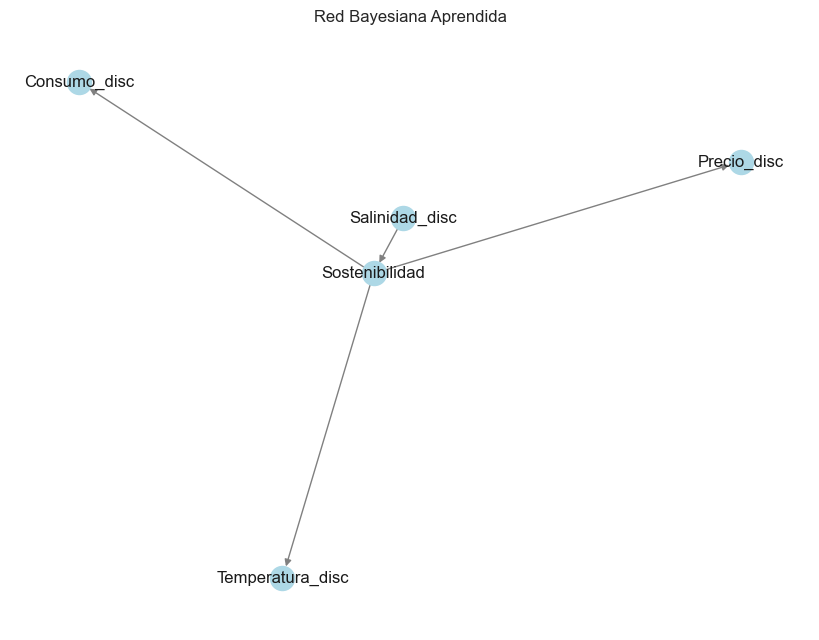

In [16]:
# Crear un grafo dirigido a partir de las aristas del modelo
nx_graph = nx.DiGraph()
nx_graph.add_edges_from(list(model.edges()))

plt.figure(figsize=(8,6))
pos = nx.spring_layout(nx_graph, seed=42)
nx.draw(nx_graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', arrows=True)
plt.title("Red Bayesiana Aprendida")
plt.show()


## 6. Inferencia en la Red Bayesiana
Realizamos una consulta de inferencia utilizando evidencia discretizada. Por ejemplo, consultamos la probabilidad de Sostenibilidad dada una Temperatura y Consumo.

In [ ]:
infer = VariableElimination(model)

# Consulta: ¿Cuál es la probabilidad de que la pesquería sea sostenible dada una Temperatura 'Medio' y Consumo 'Medio'?
consulta = infer.query(variables=['Sostenibilidad'], evidence={'Temperatura_disc': 'Medio', 'Consumo_disc': 'Medio'})
print("Consulta de sostenibilidad dada la evidencia:")
print(consulta)

## 7. Validación del Modelo (FASE A - Mejora)
Evaluamos el rendimiento del modelo utilizando métricas de clasificación estándar.

In [ ]:
# === VALIDACIÓN DEL MODELO ===

# 7.1 Split Train/Test
X = df_disc.drop('Sostenibilidad', axis=1)
y = df_disc['Sostenibilidad']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Tamaño de entrenamiento: {len(X_train)}")
print(f"Tamaño de prueba: {len(X_test)}")
print(f"Distribución en train: {y_train.value_counts().to_dict()}")
print(f"Distribución en test: {y_test.value_counts().to_dict()}")

In [ ]:
# 7.2 Entrenar modelo solo con datos de entrenamiento
df_train = pd.concat([X_train, y_train], axis=1)

# Aprender estructura con datos de entrenamiento
hc_train = HillClimbSearch(df_train)
estructura_train = hc_train.estimate(scoring_method=BIC(df_train))

# Crear y ajustar modelo de validación
model_val = BayesianNetwork(estructura_train.edges())
model_val.fit(df_train, estimator=MaximumLikelihoodEstimator)

print("Estructura aprendida en entrenamiento:", list(estructura_train.edges()))

In [ ]:
# 7.3 Función de predicción usando la red bayesiana
def predecir_con_red_bayesiana(model, X_data):
    """
    Predice la variable Sostenibilidad usando inferencia bayesiana.
    Retorna predicciones y probabilidades.
    """
    infer = VariableElimination(model)
    predicciones = []
    probabilidades = []
    
    for idx, row in X_data.iterrows():
        evidence = row.to_dict()
        try:
            resultado = infer.query(variables=['Sostenibilidad'], evidence=evidence)
            prob_1 = resultado.values[1]  # Probabilidad de Sostenibilidad=1
            predicciones.append(1 if prob_1 > 0.5 else 0)
            probabilidades.append(prob_1)
        except Exception as e:
            # Si hay error (ej: combinación no vista), usar probabilidad marginal
            predicciones.append(0)
            probabilidades.append(0.5)
    
    return np.array(predicciones), np.array(probabilidades)

# Realizar predicciones en el conjunto de prueba
print("Realizando predicciones en conjunto de prueba...")
y_pred, y_prob = predecir_con_red_bayesiana(model_val, X_test)
print(f"Predicciones completadas: {len(y_pred)} muestras")

In [ ]:
# 7.4 Cálculo de métricas de clasificación
print("=" * 60)
print("MÉTRICAS DE VALIDACIÓN - RED BAYESIANA")
print("=" * 60)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

# AUC-ROC (requiere probabilidades)
try:
    auc_roc = roc_auc_score(y_test, y_prob)
except ValueError:
    auc_roc = 0.5  # Si solo hay una clase

print(f"\nAccuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc_roc:.4f}")

print("\n" + "=" * 60)
print("REPORTE DE CLASIFICACIÓN DETALLADO")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=['Insostenible', 'Sostenible']))

In [ ]:
# 7.5 Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Insostenible', 'Sostenible'],
            yticklabels=['Insostenible', 'Sostenible'],
            ax=ax)
ax.set_xlabel('Predicción')
ax.set_ylabel('Valor Real')
ax.set_title('Matriz de Confusión - Red Bayesiana')
plt.tight_layout()
plt.show()

print(f"\nVerdaderos Negativos (TN): {cm[0,0]}")
print(f"Falsos Positivos (FP): {cm[0,1]}")
print(f"Falsos Negativos (FN): {cm[1,0]}")
print(f"Verdaderos Positivos (TP): {cm[1,1]}")

## 8. Análisis de Sensibilidad (FASE A - Mejora)
Evaluamos la robustez de la estructura aprendida mediante bootstrap y comparación de diferentes métodos de scoring.

In [ ]:
# 8.1 Bootstrap para estabilidad de estructura
from collections import Counter

def bootstrap_structure_analysis(data, n_bootstrap=50, random_state=42):
    """
    Realiza análisis de bootstrap para evaluar la estabilidad de las aristas aprendidas.
    """
    np.random.seed(random_state)
    n_samples = len(data)
    edge_counts = Counter()
    
    print(f"Ejecutando {n_bootstrap} iteraciones de bootstrap...")
    
    for i in range(n_bootstrap):
        # Muestreo con reemplazo
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        data_bootstrap = data.iloc[indices].reset_index(drop=True)
        
        # Aprender estructura
        hc = HillClimbSearch(data_bootstrap)
        estructura = hc.estimate(scoring_method=BIC(data_bootstrap))
        
        # Contar aristas
        for edge in estructura.edges():
            edge_counts[edge] += 1
        
        if (i + 1) % 10 == 0:
            print(f"  Iteración {i + 1}/{n_bootstrap} completada")
    
    return edge_counts

# Ejecutar análisis de bootstrap
edge_stability = bootstrap_structure_analysis(df_disc, n_bootstrap=50)

print("\n" + "=" * 60)
print("ESTABILIDAD DE ARISTAS (Bootstrap)")
print("=" * 60)
for edge, count in sorted(edge_stability.items(), key=lambda x: -x[1]):
    percentage = (count / 50) * 100
    print(f"{edge[0]:25} -> {edge[1]:20}: {count:3}/50 ({percentage:5.1f}%)")

In [ ]:
# 8.2 Comparación de Métodos de Scoring
print("=" * 60)
print("COMPARACIÓN DE MÉTODOS DE SCORING")
print("=" * 60)

scoring_methods = {
    'BIC Score': BIC(df_disc),
    'K2 Score': K2(df_disc),
    'BDeu Score': BDeu(df_disc)
}

estructuras_comparadas = {}

for nombre, scoring in scoring_methods.items():
    hc = HillClimbSearch(df_disc)
    estructura = hc.estimate(scoring_method=scoring)
    estructuras_comparadas[nombre] = set(estructura.edges())
    
    print(f"\n{nombre}:")
    print(f"  Número de aristas: {len(estructura.edges())}")
    print(f"  Aristas: {list(estructura.edges())}")

# Calcular coincidencia entre métodos
print("\n" + "=" * 60)
print("COINCIDENCIA ENTRE MÉTODOS")
print("=" * 60)

metodos = list(estructuras_comparadas.keys())
for i in range(len(metodos)):
    for j in range(i + 1, len(metodos)):
        m1, m2 = metodos[i], metodos[j]
        interseccion = estructuras_comparadas[m1] & estructuras_comparadas[m2]
        union = estructuras_comparadas[m1] | estructuras_comparadas[m2]
        jaccard = len(interseccion) / len(union) if union else 0
        print(f"{m1} vs {m2}:")
        print(f"  Aristas comunes: {len(interseccion)}")
        print(f"  Índice Jaccard: {jaccard:.3f}")

In [ ]:
# 8.3 Visualización de estabilidad de aristas
edges_data = [(edge, count) for edge, count in edge_stability.items()]
edges_data.sort(key=lambda x: -x[1])

# Crear gráfico de barras
fig, ax = plt.subplots(figsize=(12, 6))
labels = [f"{e[0][:8]}...→{e[1][:8]}..." for e, _ in edges_data[:10]]
values = [c for _, c in edges_data[:10]]
colors = ['green' if v >= 40 else 'orange' if v >= 25 else 'red' for v in values]

bars = ax.barh(labels, values, color=colors)
ax.set_xlabel('Frecuencia en Bootstrap (de 50)')
ax.set_title('Top 10 Aristas Más Estables')
ax.axvline(x=40, color='green', linestyle='--', label='Alta estabilidad (80%+)')
ax.axvline(x=25, color='orange', linestyle='--', label='Estabilidad media (50%+)')
ax.legend()

# Añadir valores en las barras
for bar, val in zip(bars, values):
    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{val} ({val*2}%)', va='center')

plt.tight_layout()
plt.show()

In [ ]:
# 8.4 Validación Cruzada (K-Fold)
print("=" * 60)
print("VALIDACIÓN CRUZADA (5-Fold)")
print("=" * 60)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y), 1):
    # Preparar datos del fold
    X_train_fold = X.iloc[train_idx]
    X_test_fold = X.iloc[test_idx]
    y_train_fold = y.iloc[train_idx]
    y_test_fold = y.iloc[test_idx]
    
    df_train_fold = pd.concat([X_train_fold, y_train_fold], axis=1)
    
    # Aprender estructura y ajustar modelo
    hc_fold = HillClimbSearch(df_train_fold)
    estructura_fold = hc_fold.estimate(scoring_method=BIC(df_train_fold))
    model_fold = BayesianNetwork(estructura_fold.edges())
    model_fold.fit(df_train_fold, estimator=MaximumLikelihoodEstimator)
    
    # Predecir
    y_pred_fold, _ = predecir_con_red_bayesiana(model_fold, X_test_fold)
    
    # Calcular métricas
    fold_metrics['accuracy'].append(accuracy_score(y_test_fold, y_pred_fold))
    fold_metrics['precision'].append(precision_score(y_test_fold, y_pred_fold, zero_division=0))
    fold_metrics['recall'].append(recall_score(y_test_fold, y_pred_fold, zero_division=0))
    fold_metrics['f1'].append(f1_score(y_test_fold, y_pred_fold, zero_division=0))
    
    print(f"Fold {fold}: Accuracy={fold_metrics['accuracy'][-1]:.4f}, F1={fold_metrics['f1'][-1]:.4f}")

print("\n" + "-" * 40)
print("RESUMEN VALIDACIÓN CRUZADA:")
for metric, values in fold_metrics.items():
    print(f"  {metric.capitalize():10}: {np.mean(values):.4f} (+/- {np.std(values):.4f})")

In [ ]:
# 8.5 Resumen de métricas con visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Métricas por fold
metrics_df = pd.DataFrame(fold_metrics)
metrics_df.index = [f'Fold {i+1}' for i in range(5)]
metrics_df.plot(kind='bar', ax=axes[0], colormap='viridis')
axes[0].set_title('Métricas por Fold (Validación Cruzada)')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('Score')
axes[0].legend(loc='lower right')
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='x', rotation=0)

# Gráfico 2: Distribución de métricas
metrics_summary = pd.DataFrame({
    'Mean': [np.mean(v) for v in fold_metrics.values()],
    'Std': [np.std(v) for v in fold_metrics.values()]
}, index=fold_metrics.keys())

colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']
bars = axes[1].bar(metrics_summary.index, metrics_summary['Mean'], 
                   yerr=metrics_summary['Std'], capsize=5, color=colors)
axes[1].set_title('Resumen de Métricas (Media ± Desv. Est.)')
axes[1].set_ylabel('Score')
axes[1].set_ylim(0, 1)

# Añadir valores sobre las barras
for bar, mean, std in zip(bars, metrics_summary['Mean'], metrics_summary['Std']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
                 f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("RESUMEN FINAL - FASE A COMPLETADA")
print("=" * 60)
print("✓ Código actualizado: BayesianModel → BayesianNetwork")
print("✓ Validación implementada: Train/Test split y K-Fold CV")
print("✓ Métricas calculadas: Accuracy, Precision, Recall, F1, AUC-ROC")
print("✓ Análisis de sensibilidad: Bootstrap y comparación de scoring")
print("=" * 60)

## Conclusiones y Aplicabilidad
### Conclusiones:

La Red Bayesiana aprendida muestra las relaciones condicionales entre variables ambientales, operativas y económicas.
Permite identificar cuáles son los factores críticos que influyen en la sostenibilidad de las pesquerías marinas.
La inferencia en la red permite simular intervenciones (por ejemplo, modificar el consumo o la temperatura) y ver su impacto en la sostenibilidad, lo cual es fundamental para fundamentar políticas de gestión.

### Aplicabilidad Práctica:
Este enfoque puede integrarse en sistemas de soporte para la toma de decisiones en la gestión pesquera, ayudando a los gestores a priorizar intervenciones, asignar recursos y diseñar políticas que aseguren la sostenibilidad del recurso.

### Extensiones Futuras:

- Integrar datos reales extraídos de informes oficiales (por ejemplo, del INIDEP o el Ministerio de Agricultura, Ganadería y Pesca).
- Explorar métodos híbridos que combinen redes bayesianas con otros modelos predictivos para mejorar la robustez de las inferencias.